In [1]:
import pandas as pd
import numpy as np

In [2]:
# 定義日期區間
start = "2018-01-01"
end = "2024-08-31"

# 定義初始投資金額
portfolio_value = 1000000

# 定義資產代號
stock = '006208.TW'
bond = '00687B.TWO'
gold = '00708L.TW'

# 定義資產比重
stock_ratio = 0.6
bond_ratio = 0.2
gold_ratio = 0.2

# 定義再平衡週期
rebalance_cycle = 'month'

In [3]:
import yfinance as yf

query = f'{stock} {bond} {gold}'
df_portfolio = yf.download(query, start = start, end = end, group_by = 'ticker')
df_TWII = yf.download("^TWII", start = start, end = end, group_by = 'ticker')

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# 獲取調整後的收盤價
df_portfolio = df_portfolio.xs('Adj Close', axis=1, level=1)
df_TWII = df_TWII[["Adj Close"]]
df_TWII.columns = ['TWII']

In [5]:
# 計算TWII的累積報酬率
df_TWII_return = df_TWII['TWII'].pct_change()
cumulative_returns_TWII = (1 + df_TWII_return).cumprod() - 1

In [6]:
if rebalance_cycle == 'year':
    rebalance_index = df_portfolio.index.year
elif rebalance_cycle == 'month':
    rebalance_index = df_portfolio.index.month
else:
    rebalance_index = df_portfolio.index.day
rebalance_index

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype='int32', name='Date', length=1619)

In [7]:
# 初始化結果
portfolio_values = []
# rebalance_dates = pd.date_range(start=start, end=end, freq='YS')  # YS表示年初
weights = np.array([stock_ratio, bond_ratio, gold_ratio])

for i in range(len(df_portfolio)):
    # 初始化投資組合價值
    if (i == 0):
        allocated_value = portfolio_value * weights
        portfolio_values.append(portfolio_value)
        continue

    # 如果是再平衡日期，重新分配資金
    if (rebalance_index[i] != rebalance_index[i-1]):
        allocated_value = portfolio_value * weights
    
    # 計算當日報酬
    daily_return = (df_portfolio.iloc[i] / df_portfolio.iloc[i-1]) - 1
    allocated_value = allocated_value + (allocated_value * daily_return)
    
    
    # 更新投資組合價值
    portfolio_value = allocated_value.sum()
    portfolio_values.append(round(portfolio_value))

df_portfolio_values = pd.DataFrame(portfolio_values, index=df_portfolio.index, columns=['Portfolio'])

# 計算累積報酬率
df_portfolio_return = df_portfolio_values['Portfolio'].pct_change()
cumulative_returns_portfolio = (1 + df_portfolio_return).cumprod() - 1

In [8]:
df_returns = pd.concat([cumulative_returns_portfolio, cumulative_returns_TWII], axis=1)
df_returns.iloc[-1:]

,Portfolio,TWII
Date,,
2024-08-30,0.935223,1.079045


In [9]:
df_compare = pd.DataFrame(df_returns.iloc[-1].values.reshape(1, -1), columns = df_returns.columns + "(%)", index = ['報酬率'])
df_compare = (df_compare * 100).round(2)
df_compare

,Portfolio(%),TWII(%)
報酬率,93.52,107.9


In [10]:
def calculate_max_drawdown(returns):
    """計算最大跌幅"""
    cumulative_returns = (1 + returns).cumprod() # 計算累積收益
    rolling_max = cumulative_returns.cummax() # 計算歷史最大累積收益
    drawdown = (cumulative_returns - rolling_max) / rolling_max # 計算當前值與過去最高點之間的差距來得出最大跌幅
    max_drawdown = drawdown.min() # 最大跌幅(負最小值)
    return round(max_drawdown * 100, 2)

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """計算夏普比率"""
    excess_returns = returns - (risk_free_rate / periods_per_year) # 超額報酬 = 收益率 - 無風險利率(日)
    sharpe_ratio =  (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) # sharpe_ratio = (超額報酬平均值(日) * n) / (標準差(日) * 根號n)，n為一年交易日
    return round(sharpe_ratio * 100, 2)

# 假設 df_portfolio_return 和 df_TWII_return 已經計算好了
# 計算最大跌幅
max_drawdown_portfolio = calculate_max_drawdown(df_portfolio_return)
max_drawdown_TWII = calculate_max_drawdown(df_TWII_return)

# 計算夏普比率
sharpe_ratio_portfolio = calculate_sharpe_ratio(df_portfolio_return)
sharpe_ratio_TWII = calculate_sharpe_ratio(df_TWII_return)

df_compare.loc['最大跌幅'] = [max_drawdown_portfolio, sharpe_ratio_portfolio]
df_compare.loc['Sharpe Ratio'] = [max_drawdown_TWII, sharpe_ratio_TWII]
df_compare

,Portfolio(%),TWII(%)
報酬率,93.52,107.90
最大跌幅,-35.21,52.55
Sharpe Ratio,-31.63,63.03


In [11]:
returns = df_TWII_return.copy()
cumulative_returns = (1 + returns).cumprod() # 計算累積收益
rolling_max = cumulative_returns.cummax() # 計算歷史最大累積收益
drawdown = (cumulative_returns - rolling_max) / rolling_max # 計算當前值與過去最高點之間的差距來得出最大跌幅
max_drawdown = drawdown.min() # 最大跌幅(負最小值)

In [12]:
df_TWII

,TWII
Date,
2018-01-02,10710.730469
2018-01-03,10801.570312
2018-01-04,10848.629883
2018-01-05,10879.799805
2018-01-08,10915.750000
...,...
2024-08-26,22240.119141
2024-08-27,22185.000000
2024-08-28,22370.660156


In [13]:
(1009260 / 10710.730469) - 1

93.22886729538148

In [14]:
df_TWII_return

Date
2018-01-02         NaN
2018-01-03    0.008481
2018-01-04    0.004357
2018-01-05    0.002873
2018-01-08    0.003304
                ...   
2024-08-26    0.003704
2024-08-27   -0.002478
2024-08-28    0.008369
2024-08-29   -0.007546
2024-08-30    0.002984
Name: TWII, Length: 1619, dtype: float64

In [15]:
cumulative_returns

Date
2018-01-02         NaN
2018-01-03    1.008481
2018-01-04    1.012875
2018-01-05    1.015785
2018-01-08    1.019142
                ...   
2024-08-26    2.076433
2024-08-27    2.071287
2024-08-28    2.088621
2024-08-29    2.072860
2024-08-30    2.079045
Name: TWII, Length: 1619, dtype: float64

In [16]:
rolling_max

Date
2018-01-02         NaN
2018-01-03    1.008481
2018-01-04    1.012875
2018-01-05    1.015785
2018-01-08    1.019142
                ...   
2024-08-26    2.277158
2024-08-27    2.277158
2024-08-28    2.277158
2024-08-29    2.277158
2024-08-30    2.277158
Name: TWII, Length: 1619, dtype: float64

In [17]:
drawdown

Date
2018-01-02         NaN
2018-01-03    0.000000
2018-01-04    0.000000
2018-01-05    0.000000
2018-01-08    0.000000
                ...   
2024-08-26   -0.088147
2024-08-27   -0.090407
2024-08-28   -0.082795
2024-08-29   -0.089716
2024-08-30   -0.087000
Name: TWII, Length: 1619, dtype: float64

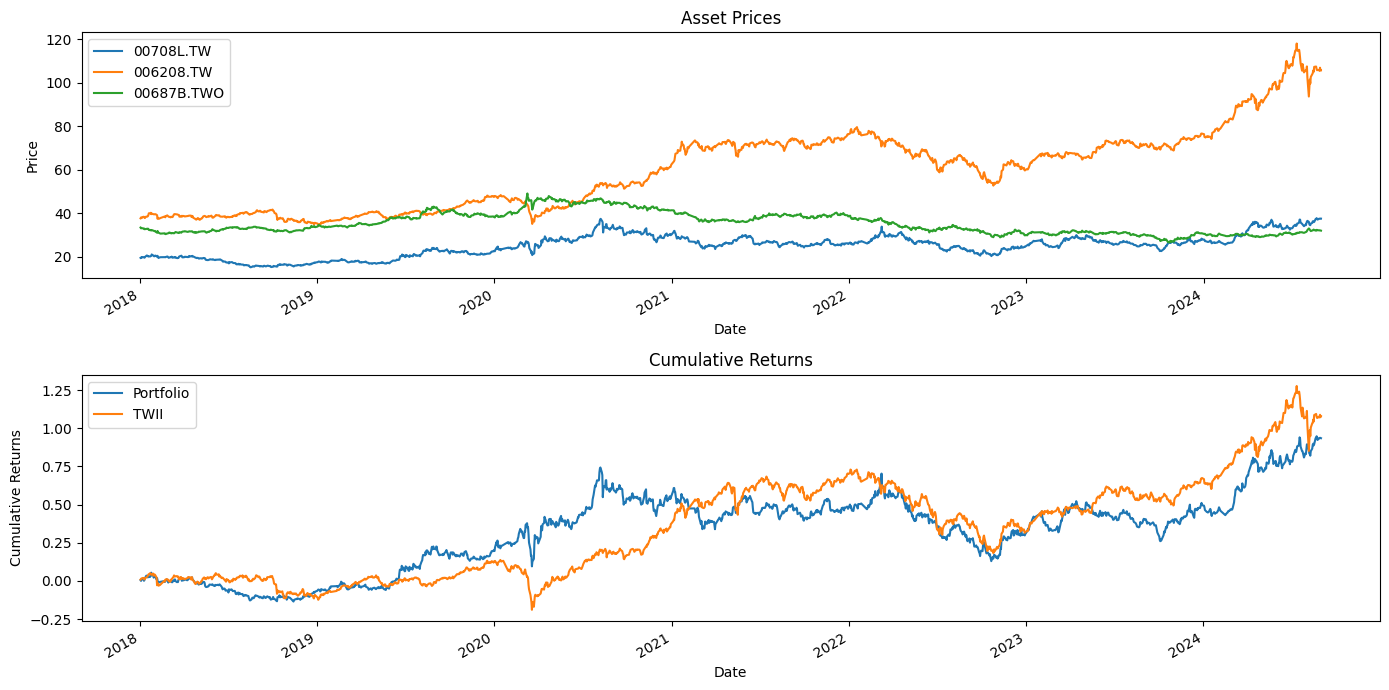

In [18]:
import matplotlib.pyplot as plt

# 繪製股價走勢圖
plt.figure(figsize=(14, 7))

# 三個資產的價格走勢
plt.subplot(2, 1, 1)
df_portfolio.plot(ax=plt.gca())
plt.title('Asset Prices')
plt.ylabel('Price')

# 投資組合的累積回報
plt.subplot(2, 1, 2)
df_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()